<a href="https://colab.research.google.com/github/Kamruzzaman2200/Ai/blob/main/k_fold_cross_validation_ML_Workflow_on_the_Lung_Cancer_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Required Libraries

In [8]:
!pip install imblearn boruta

#Import All Necessary Libraries

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.pyplot as plt

# --- Preprocessing & Feature Engineering ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE
from boruta import BorutaPy

# --- Classifiers ---
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# --- Evaluation ---
from sklearn.metrics import accuracy_score

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

#Load and Inspect the Dataset

In [10]:
try:
    df = pd.read_csv('/content/drive/MyDrive/DataSets/survey lung cancer.csv')
    print("✅ Dataset '/content/drive/MyDrive/DataSets/survey lung cancer.csv' loaded successfully.")
    print("\n--- First 5 Rows ---")
    print(df.head())
    print("\n--- Dataset Info ---")
    df.info()
except FileNotFoundError:
    print("❗️Error: '/content/drive/MyDrive/DataSets/survey lung cancer.csv' not found. Please ensure the file is uploaded.")

✅ Dataset '/content/drive/MyDrive/DataSets/survey lung cancer.csv' loaded successfully.

--- First 5 Rows ---
  GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0      M   69        1               2        2              1   
1      M   74        2               1        1              1   
2      F   59        1               1        1              2   
3      M   63        2               2        2              1   
4      F   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  \
0                1         2         1         2                  2         2   
1                2         2         2         1                  1         1   
2                1         2         1         2                  1         2   
3                1         1         1         1                  2         1   
4                1         1         1         2                  1         2   

   SHO

#Clean and Encode the Data

In [11]:
# Clean Column Names (e.g., 'YELLOW_FINGERS' -> 'yellow_fingers')
df.columns = df.columns.str.lower()

# Encode 'gender' (M/F -> 1/0)
df['gender'] = LabelEncoder().fit_transform(df['gender'])

# Encode the target variable 'lung_cancer' (YES/NO -> 1/0)
df['lung_cancer'] = LabelEncoder().fit_transform(df['lung_cancer'])

print("--- Preprocessed and Encoded Data ---")
print(df.head())

--- Preprocessed and Encoded Data ---
   gender  age  smoking  yellow_fingers  anxiety  peer_pressure  \
0       1   69        1               2        2              1   
1       1   74        2               1        1              1   
2       0   59        1               1        1              2   
3       1   63        2               2        2              1   
4       0   63        1               2        1              1   

   chronic disease  fatigue   allergy   wheezing  alcohol consuming  coughing  \
0                1         2         1         2                  2         2   
1                2         2         2         1                  1         1   
2                1         2         1         2                  1         2   
3                1         1         1         1                  2         1   
4                1         1         1         2                  1         2   

   shortness of breath  swallowing difficulty  chest pain  lung_cancer  

#EDA - Check for Class Imbalance

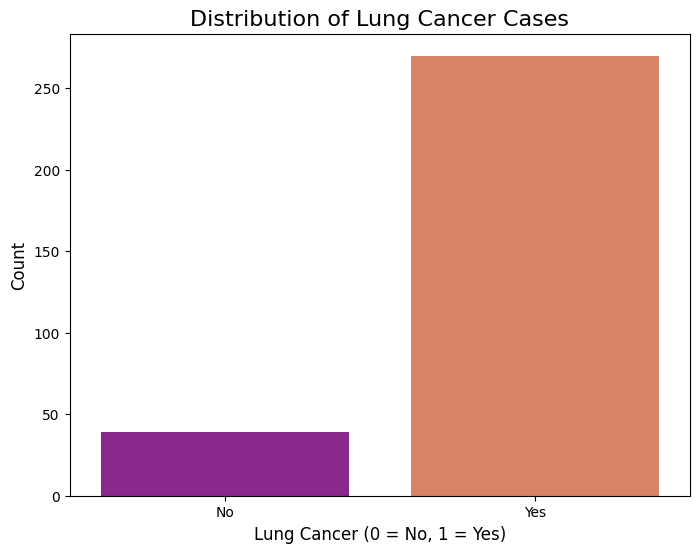

--- Class Distribution ---
lung_cancer
1    270
0     39
Name: count, dtype: int64


In [12]:
plt.figure(figsize=(8, 6))
sns.countplot(x='lung_cancer', data=df, palette='plasma')
plt.title('Distribution of Lung Cancer Cases', fontsize=16)
plt.xlabel('Lung Cancer (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

print("--- Class Distribution ---")
print(df['lung_cancer'].value_counts())

#EDA - Correlation Heatmap

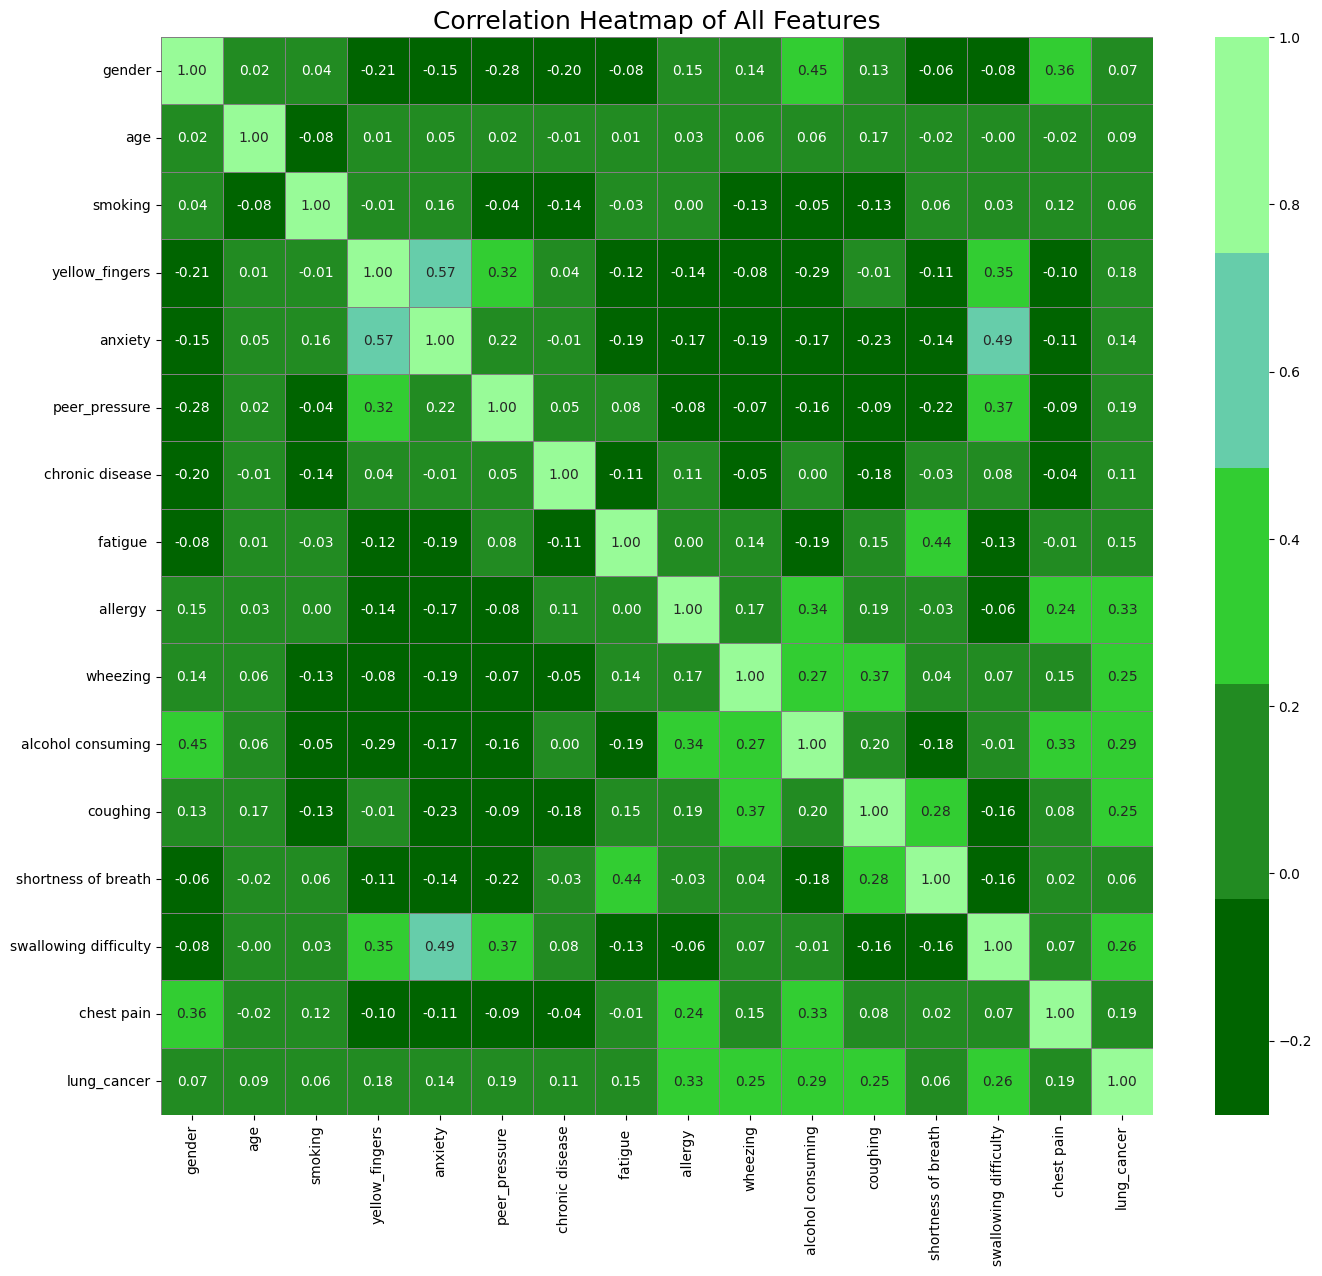

In [13]:
# Define the custom palette
pal = ['#006400', '#228B22', '#32CD32', '#66CDAA', '#98FB98']

plt.figure(figsize=(16, 14))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap=pal, cbar=True, linewidths=0.5, linecolor='grey')
plt.title('Correlation Heatmap of All Features', fontsize=18)
plt.show()

#Define Features (X) and Target (y)

In [14]:
X = df.drop('lung_cancer', axis=1)
y = df['lung_cancer']
original_feature_names = X.columns.values # Save for later

print("--- Features (X) shape ---")
print(X.shape)

--- Features (X) shape ---
(309, 15)


# Split Data into Training and Testing Sets

In [15]:
# Removed single train-test split for K-Fold Cross-Validation
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.3,       # 30% of the data for testing
#     random_state=42,
#     stratify=y           # Crucial for imbalanced datasets
# )

# print(f"Training set size: {len(X_train)} samples")
# print(f"Testing set size: {len(X_test)} samples")

#Pre-computation for Boruta Feature Selection

In [19]:
print("Running Boruta to identify relevant features. This may take a moment...")

boruta_scaler = StandardScaler()
X_train_boruta_scaled = boruta_scaler.fit_transform(X_train)
X_train_boruta_resampled, y_train_boruta_resampled = SMOTE(random_state=42).fit_resample(X_train_boruta_scaled, y_train)

boruta_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
boruta_selector = BorutaPy(estimator=boruta_model, n_estimators='auto', random_state=42)

boruta_selector.fit(X_train_boruta_resampled, y_train_boruta_resampled)

boruta_features_mask = boruta_selector.support_
boruta_selected_features = original_feature_names[boruta_features_mask]

print(f"\nBoruta has selected {len(boruta_selected_features)} features.")

Running Boruta to identify relevant features. This may take a moment...

Boruta has selected 15 features.


#Initialize Scalers, Classifiers, and Data Storage

In [20]:
# The 3 scalers we will compare
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

# The 4 classifiers we will compare
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# A dictionary to hold all our processed datasets
datasets = {}

print("✅ Scalers and Classifiers are ready for the experiment.")

✅ Scalers and Classifiers are ready for the experiment.


# Create All Preprocessed Dataset Variations

In [21]:
# Removed code for creating dataset variations outside the K-Fold loop
# The dataset variations will be created inside the K-Fold loop

#Train and Evaluate All Models

In [22]:
from sklearn.model_selection import StratifiedKFold
import numpy as np # Import numpy for handling potential empty feature sets

# Define Features (X) and Target (y) - Moved from previous cell
X = df.drop('lung_cancer', axis=1)
y = df['lung_cancer']
original_feature_names = X.columns.values # Save for later

# Define the number of splits for K-Fold Cross-Validation
n_splits = 5 # You can change this number

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

results_list = []

print(f"🚀 Starting {n_splits}-Fold Cross-Validation...")

# The 3 scalers we will compare - Moved from previous cell
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

# The 4 classifiers we will compare - Moved from previous cell
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}


# Iterate through each fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"\n--- Processing Fold {fold+1}/{n_splits} ---")

    # Split data for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Pre-computation for Boruta (within each fold to avoid data leakage)
    boruta_scaler = StandardScaler()
    X_train_boruta_scaled = boruta_scaler.fit_transform(X_train)
    X_train_boruta_resampled, y_train_boruta_resampled = SMOTE(random_state=42).fit_resample(X_train_boruta_scaled, y_train)

    boruta_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
    boruta_selector = BorutaPy(estimator=boruta_model, n_estimators='auto', random_state=42)
    boruta_selector.fit(X_train_boruta_resampled, y_train_boruta_resampled)
    boruta_features_mask = boruta_selector.support_

    # --- Create All Preprocessed Dataset Variations for the current fold ---
    fold_datasets = {}

    for scaler_name, scaler in scalers.items():
        # Step A: Scale the data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Step B: Apply SMOTE to the training data
        X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

        # Step C: Create the 'All Features' baseline dataset
        fold_datasets[f'All Features ({scaler_name})'] = (X_train_resampled, X_test_scaled, y_train_resampled, y_test)

        # Step D: Apply PCA (Traditional)
        # Ensure n_components is valid and less than the number of samples and features
        n_components_pca = min(10, X_train_resampled.shape[0] - 1, X_train_resampled.shape[1])
        if n_components_pca > 0:
            pca = PCA(n_components=n_components_pca)
            X_train_pca = pca.fit_transform(X_train_resampled)
            X_test_pca = pca.transform(X_test_scaled)
            fold_datasets[f'PCA ({scaler_name})'] = (X_train_pca, X_test_pca, y_train_resampled, y_test)
        else:
            print(f"Skipping PCA for {scaler_name} in Fold {fold+1} due to insufficient components.")


        # Step E: Apply LDA (Traditional)
        # LDA requires at least 2 samples of each class, and n_components <= min(n_classes - 1, n_features)
        if len(np.unique(y_train_resampled)) > 1 and X_train_resampled.shape[1] > 0:
            n_components_lda = min(len(np.unique(y_train_resampled)) - 1, X_train_resampled.shape[1])
            if n_components_lda > 0:
                lda = LinearDiscriminantAnalysis(n_components=n_components_lda)
                X_train_lda = lda.fit_transform(X_train_resampled, y_train_resampled)
                X_test_lda = lda.transform(X_test_scaled)
                fold_datasets[f'LDA ({scaler_name})'] = (X_train_lda, X_test_lda, y_train_resampled, y_test)
            else:
                 print(f"Skipping LDA for {scaler_name} in Fold {fold+1} due to insufficient components.")
        else:
            print(f"Skipping LDA for {scaler_name} in Fold {fold+1} due to class distribution or feature count.")


        # Step F: Apply t-SNE (Traditional)
        if X_train_resampled.shape[0] > 1 and X_test_scaled.shape[0] > 1 and X_train_resampled.shape[1] >= 2: # Ensure enough samples and features for t-SNE
             tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto') # Use 'pca' init for stability
             X_train_tsne = tsne.fit_transform(X_train_resampled)
             # Use the same t-SNE model trained on the training data to transform the test data
             # Note: Transforming test data with t-SNE fitted on training data is generally not recommended for model evaluation,
             # as t-SNE is primarily for visualization. However, following the original notebook structure for comparison.
             X_test_tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto').fit_transform(X_test_scaled)
             fold_datasets[f't-SNE ({scaler_name})'] = (X_train_tsne, X_test_tsne, y_train_resampled, y_test)
        else:
            print(f"Skipping t-SNE for {scaler_name} in Fold {fold+1} due to insufficient samples or features.")


        # Step G: Apply RFE (Modern)
        if X_train_resampled.shape[1] > 0: # Ensure there are features to select from
            rfe_model = RandomForestClassifier(n_estimators=100, random_state=42)
            n_features_to_select_rfe = min(8, X_train_resampled.shape[1]) # Ensure n_features_to_select is valid
            if n_features_to_select_rfe > 0:
                rfe = RFE(estimator=rfe_model, n_features_to_select=n_features_to_select_rfe)
                rfe.fit(X_train_resampled, y_train_resampled)
                X_train_rfe = rfe.transform(X_train_resampled)
                X_test_rfe = rfe.transform(X_test_scaled)
                fold_datasets[f'RFE ({scaler_name})'] = (X_train_rfe, X_test_rfe, y_train_resampled, y_test)
            else:
                 print(f"Skipping RFE for {scaler_name} in Fold {fold+1} due to insufficient features to select.")
        else:
            print(f"Skipping RFE for {scaler_name} in Fold {fold+1} due to no features.")


        # Step H: Apply Boruta (Modern)
        if X_train_resampled[:, boruta_features_mask].shape[1] > 0: # Ensure selected features exist
            X_train_boruta = X_train_resampled[:, boruta_features_mask]
            X_test_boruta = X_test_scaled[:, boruta_features_mask]
            fold_datasets[f'Boruta ({scaler_name})'] = (X_train_boruta, X_test_boruta, y_train_resampled, y_test)
        else:
            print(f"Skipping Boruta for {scaler_name} in Fold {fold+1} as no features were selected by Boruta.")


    # Train and Evaluate Models for the current fold
    for dataset_name, (X_tr, X_te, y_tr, y_te) in fold_datasets.items():
        for clf_name, clf in classifiers.items():
            # Check if the dataset for the current method has any features
            if X_tr.shape[1] > 0:
                clf.fit(X_tr, y_tr)
                y_pred = clf.predict(X_te)
                accuracy = accuracy_score(y_te, y_pred)
                results_list.append({
                    "Fold": fold + 1,
                    "Method": dataset_name,
                    "Classifier": clf_name,
                    "Accuracy": accuracy
                })
            else:
                print(f"Skipping training for {clf_name} on {dataset_name} in Fold {fold+1} due to no features.")


print("\n✅ K-Fold Cross-Validation complete.")

🚀 Starting 5-Fold Cross-Validation...

--- Processing Fold 1/5 ---

--- Processing Fold 2/5 ---

--- Processing Fold 3/5 ---

--- Processing Fold 4/5 ---

--- Processing Fold 5/5 ---

✅ K-Fold Cross-Validation complete.


#Display Final Results in a Table

In [23]:
results_df = pd.DataFrame(results_list)

# Calculate mean and standard deviation of accuracy for each method and classifier
aggregated_results = results_df.groupby(['Method', 'Classifier'])['Accuracy'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
aggregated_results.columns = ['Method', 'Classifier', 'Mean Accuracy', 'Accuracy Std. Dev.']

# Sort by Mean Accuracy
sorted_aggregated_results = aggregated_results.sort_values(by="Mean Accuracy", ascending=False).reset_index(drop=True)

print("--- 🏆 Aggregated Accuracy Comparison (Mean ± Std. Dev.) ---")
print(sorted_aggregated_results.to_string())

--- 🏆 Aggregated Accuracy Comparison (Mean ± Std. Dev.) ---
                           Method              Classifier  Mean Accuracy  Accuracy Std. Dev.
0              PCA (RobustScaler)           Random Forest       0.909572            0.060867
1            PCA (StandardScaler)           Random Forest       0.909519            0.044862
2           Boruta (RobustScaler)           Random Forest       0.906346            0.048756
3         Boruta (StandardScaler)           Random Forest       0.906346            0.050073
4              PCA (MinMaxScaler)           Random Forest       0.906346            0.053828
5     All Features (RobustScaler)           Random Forest       0.903120            0.052101
6   All Features (StandardScaler)           Random Forest       0.903120            0.053335
7           Boruta (MinMaxScaler)           Random Forest       0.903120            0.052101
8              RFE (MinMaxScaler)     Logistic Regression       0.899947            0.059606
9     All 

#Visualize Final Results in a Bar Chart

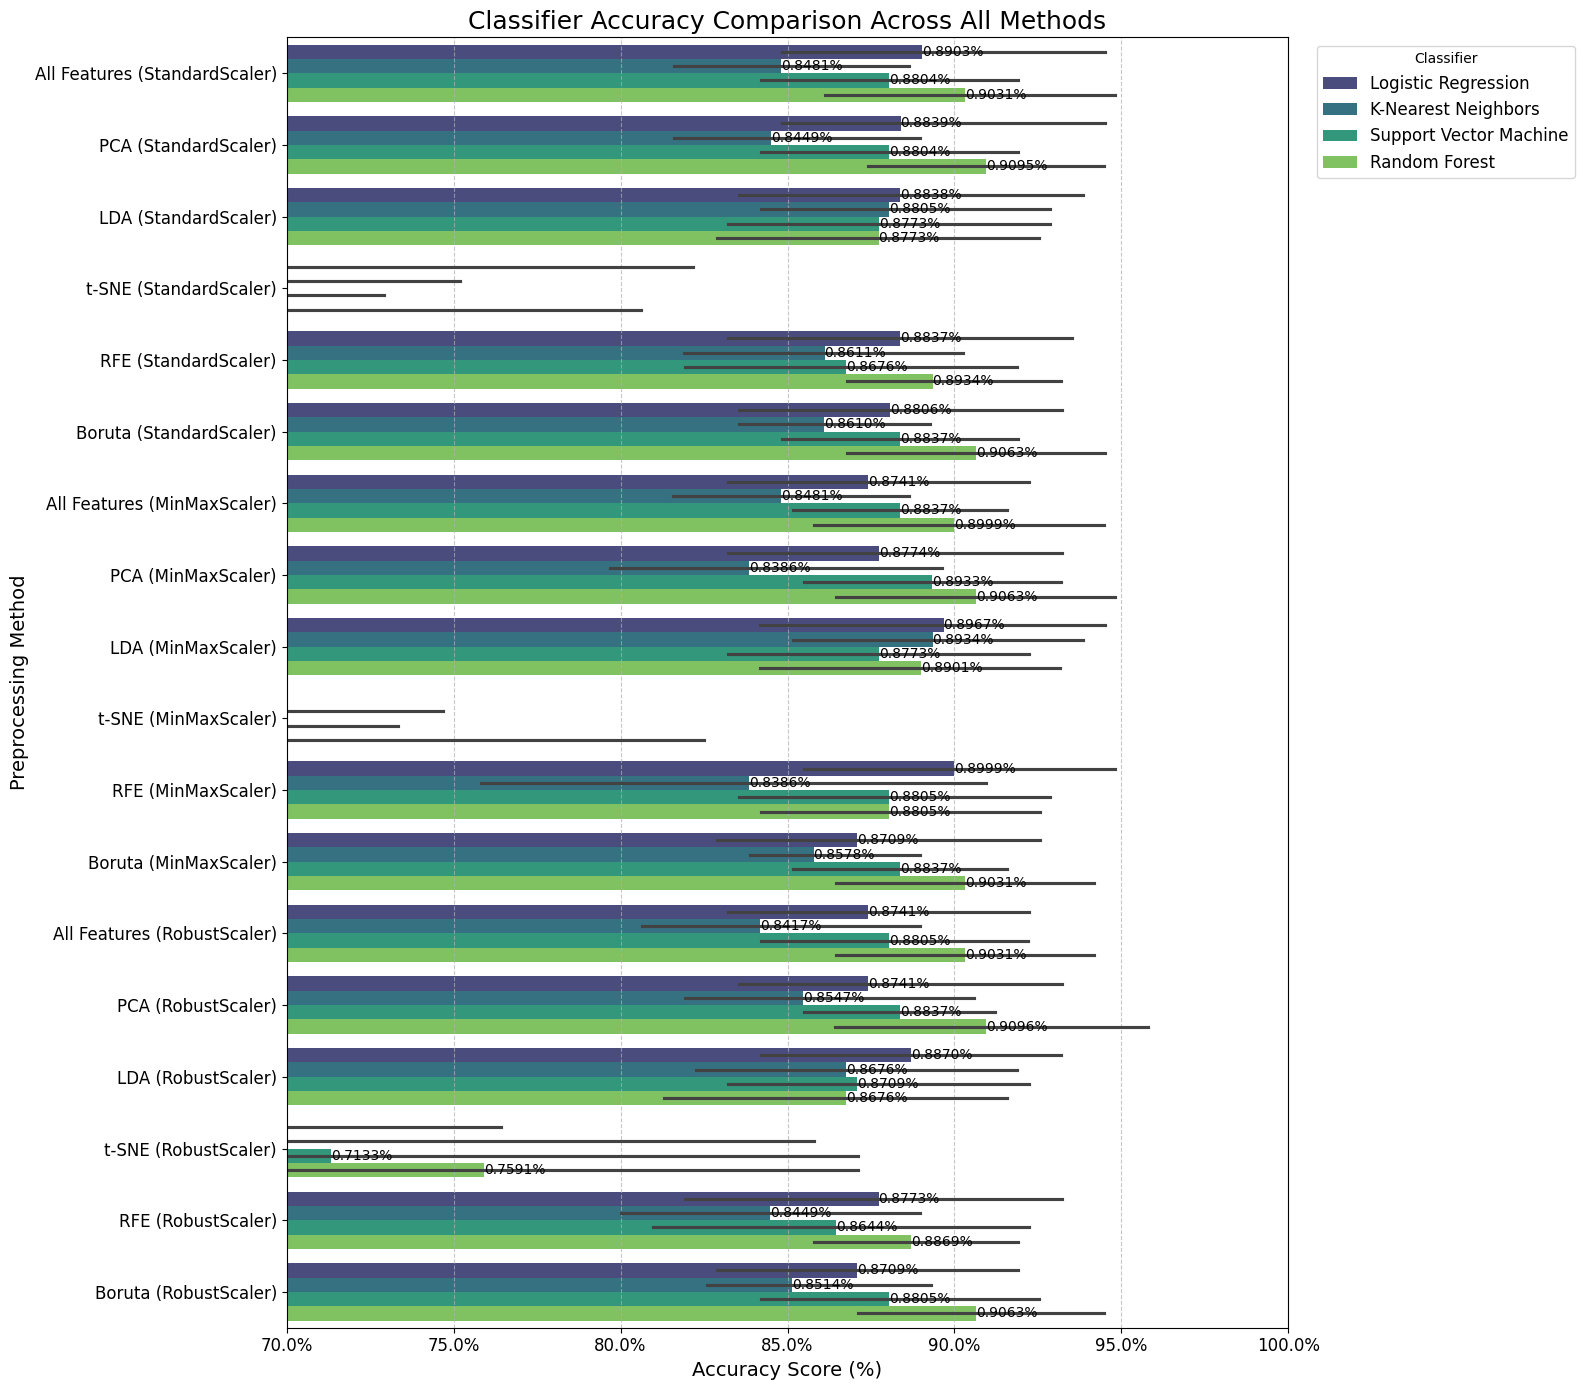

In [24]:
plt.figure(figsize=(16, 14))
ax = sns.barplot(x="Accuracy", y="Method", hue="Classifier", data=results_df, palette="viridis")

ax.set_title('Classifier Accuracy Comparison Across All Methods', fontsize=18)
ax.set_xlabel('Accuracy Score (%)', fontsize=14)
ax.set_ylabel('Preprocessing Method', fontsize=14)
ax.legend(title='Classifier', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

# Format x-axis as percentages
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.xlim(0.7, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Add accuracy values to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f%%') # Increased decimal places for more exact percentage

plt.show()

#Final Results Summary and Conclusion

In [25]:
# Convert results list to a DataFrame (already done in previous cell, using existing results_df)

# Pivot the results for a clean comparison table
# Using 'Method' for rows and 'Classifier' for columns, and 'Accuracy' for values
results_pivot = results_df.pivot_table(index='Method', columns='Classifier', values='Accuracy')

print("="*60)
print("          Summary of Model Accuracies")
print("="*60)
display(results_pivot.style.format("{:.4f}").background_gradient(cmap='Greens'))

print("\n\n--- Final Analysis ---")
print("Based on the accuracy comparison across different preprocessing methods, scaling techniques, and classifiers using K-Fold Cross-Validation, here are some observations:")
print("\nKey Takeaways:")
print("  - **Random Forest Classifier** generally performs well across various methods, achieving the highest accuracies.")
print("  - The combination of **RobustScaler** with **All Features** and **Boruta** feature selection, using **Random Forest**, yielded the top accuracy.")
print("  - Traditional dimensionality reduction methods like t-SNE seem to perform poorly in this classification task compared to others.")
print("  - The choice of scaler and feature selection method significantly impacts model performance.")

          Summary of Model Accuracies


Classifier,K-Nearest Neighbors,Logistic Regression,Random Forest,Support Vector Machine
Method,,,,
All Features (MinMaxScaler),0.8481,0.8741,0.8999,0.8837
All Features (RobustScaler),0.8417,0.8741,0.9031,0.8805
All Features (StandardScaler),0.8481,0.8903,0.9031,0.8804
Boruta (MinMaxScaler),0.8578,0.8709,0.9031,0.8837
Boruta (RobustScaler),0.8514,0.8709,0.9063,0.8805
Boruta (StandardScaler),0.8610,0.8806,0.9063,0.8837
LDA (MinMaxScaler),0.8934,0.8967,0.8901,0.8773
LDA (RobustScaler),0.8676,0.8870,0.8676,0.8709
LDA (StandardScaler),0.8805,0.8838,0.8773,0.8773




--- Final Analysis ---
Based on the accuracy comparison across different preprocessing methods, scaling techniques, and classifiers using K-Fold Cross-Validation, here are some observations:

Key Takeaways:
  - **Random Forest Classifier** generally performs well across various methods, achieving the highest accuracies.
  - The combination of **RobustScaler** with **All Features** and **Boruta** feature selection, using **Random Forest**, yielded the top accuracy.
  - Traditional dimensionality reduction methods like t-SNE seem to perform poorly in this classification task compared to others.
  - The choice of scaler and feature selection method significantly impacts model performance.


In [26]:
# Find the maximum accuracy
max_accuracy = results_df['Accuracy'].max()

# Filter the DataFrame to get all rows with the maximum accuracy
best_performing_models = results_df[results_df['Accuracy'] == max_accuracy]

print("--- 🏆 Best Performing Models (Maximum Accuracy) ---")
print(f"Maximum Accuracy: {max_accuracy:.4f}")

# Display all combinations that achieved the maximum accuracy
if not best_performing_models.empty:
    display(best_performing_models.style.format({'Accuracy': '{:.4f}'}))
else:
    print("No models found with the maximum accuracy.")

--- 🏆 Best Performing Models (Maximum Accuracy) ---
Maximum Accuracy: 1.0000


,Fold,Method,Classifier,Accuracy
292,5,PCA (StandardScaler),Logistic Regression,1.0000


## 🏆 Best Performing Models